1. [Amazon OpenSearch (formerly known as ElasticSearch)](#amazon-opensearch-formerly-known-as-elasticsearch)
2. [Open Search Applications](#open-search-applications)
3. [OpenSearch Concepts](#opensearch-concepts)
4. [Amazon OpenSearch (non serverless)](#amazon-opensearch-non-serverless)
5. [Amazon OpenSearch Security](#amazon-opensearch-security)
6. [Securing Dashboard in VPC](#securing-dashboard-in-vpc)
7. [Amazon OpenSearch Anti Patterns](#amazon-opensearch-anti-patterns)
8. [Storage Types on OpenSearch](#storage-types-on-opensearch)
9. [Index State Management](#index-state-management)
10. [OpenSearch Stability](#opensearch-stability)
11. [OpenSearch Performance](#opensearch-performance)
12. [Amazon OpenSearch (serverless)](#amazon-opensearch-serverless)

#### Amazon OpenSearch (formerly known as ElasticSearch):

Elastic Search:
- Elastic Search is not only used for searching but also for analysis and reporting
- Analyzing data in Elastic Search is also faster than Apache Spark
- ElasticSearch, Kibana (visualization tool) & Beats (data injection tool) are Elastic Stack
- ElasticSearch built on top of Lucene, an open source solution

Open Search:
- Its a fork of ElasticSearch and Kibana
- OpenSearch is a branch of ElasticSearch
- OpenSearch is like a search engine, analytics, visualization tool (Kibana = Dashboards)
- OpenSearch is very good for analyzing massive datasets
- We send JSON requests to Open Search to perform search operation, fuzzy matching or any analysis operation
- OpenSearch is an scalable version of Lucene and its distributed across many nodes in a cluster
- Serves as a data pipeline 
    - used Kinesis to configure and send data into OpenSearch (similar to Beats and LogStash which were used in ElasticSearch)

#### Open Search Applications:
- full text search (eg: Wikipedia search)
- Log Analytics
- Application Monitoring
- Security Analytics
- Clickstream Analytics

#### OpenSearch Concepts:

Documents:
- documents are things that we search for
- they can be more than texts
- each document has a unique ID and type

Types:
- schema and mapping shared by documents

Indices:
- it powers search into all documents within a collection of types
    - In other words, index is a list of words contained in a document.
- contains inverted index that lets us search across everything within them at once
    - In other words, inverted index is a list of documents containing a word.


In [7]:
""" 
A forward index would store { Document1: ["Hello", "this", "is", "a", "document"] }, 
An inverted index would store (for example) { "Hello": [Document1], "this": [Document1, Document40] }
"""

' \nA forward index would store { Document1: ["Hello", "this", "is", "a", "document"] }, \nAn inverted index would store (for example) { "Hello": [Document1], "this": [Document1, Document40] }\n'

- An index is split into shards
- Documents are hashed into a shard
- Each shard maybe on a different node in a cluster
- Each shard is a self contained Lucene index of its own

ElasticSearch Structure:
- Index split into -> shards-> distributed to various nodes -> various nodes form a cluster 
- in comparison with SQL
    - Index = Database
    - Documents = rows
    - Properties = columns

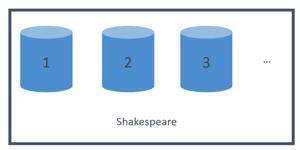

In [3]:
from PIL import Image 
from IPython.display import display

img = Image.open('images/index.jpeg')
new_image = img.resize((300, 150))
display(new_image)

- Index has 2 primary and 2 replicas 
- Application should round robin requests amongst nodes
- Write requests are routed to primary shard 
- Read requests are routed to replica shard or primary shards

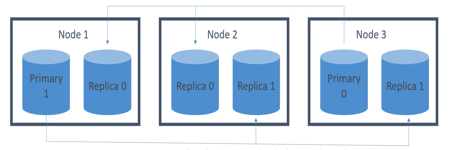

In [6]:
from PIL import Image 
from IPython.display import display

img = Image.open('images/index1.jpeg')
new_image = img.resize((450, 150))
display(new_image)

#### Amazon OpenSearch (non serverless):
- fully managed
- not automatic scaling
- pay for what you use
- network isolation
- aws integration
    - DynamoDB Streams
    - Kinesis Data Streams
    - S3 buckets
    - CloudWatch/CloudTrail
    - Zone awareness

#### Amazon OpenSearch Options:
- Dedicated master nodes (master nodes are used for the management of OpenSearch)
    - count and instance types
- Domains (collection of resources need to run OpenSearch cluster and its Amazon Specific i.e. the configuration)
- Snapshot to S3
- Zone Awareness but at the price of high latency

#### Amazon OpenSearch Security:
- Resource-based policy
- Identity policy
- IP-based policy
- Request signing
- VPC (custom, but difficult to establish connection with other AWS resources)
- Cognito
- we configure security policies for each individual domain 

#### Securing Dashboard in VPC:
- using cognito with enterprise identity provider of Microsoft's Active Directory using SAML 2.0 or via social identity providers such as Google, Facebook or Amazon allow users to access the OpenSearch inside the VPC
- Options of getting into Dashboard from VPC:
    - use Nginx reverse proxy on EC2 forwarding to ES domain (OpenSearch)
    - open SSH tunnel for port 5601 which the dashboard (OpenSearch Kibana) listen on
    - Other options of getting into Dashboard from VPC:
        - use VPC Direct Connect
        - VPN

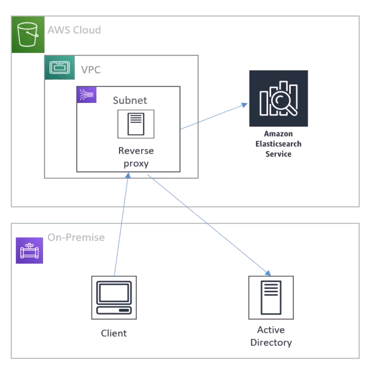

In [7]:
from PIL import Image 
from IPython.display import display

img = Image.open('images/vpc.jpeg')
new_image = img.resize((370, 370))
display(new_image)

#### Amazon OpenSearch Anti Patterns:

OLTP:
- no transactions
- RDS or DynamoDB is better

Ad-hoc data querying:
- Athena is better

#### Storage Types on OpenSearch:
- Cold
    - uses S3
    - cheapest of all
    - for periodic research or forensic analysis on older data
    - to use cold storage, we should also enable Warm/Ultra Warm storage
    - needs dedicated master
    - We cannot use cold storage of T2 or T3 instance type on data nodes 
    - for fine grain access control, we should map users to cold_manager role in OpenSearch dashboard

- Warm or Ultra-Warm
    - uses S3 + caching
    - best for indices with few writes (log data / immutable)
    - slower performance compared to hot storage and less costly
    - must have dedicated master node

- Hot Storage
    - data nodes in OpenSearch use hot storage by default
    - instance stores or EBS volume 
    - will give fastest performance
    - most expensive
    
Note:
- We can migrate between the storage types if needed

#### Index State Management:
- automates index management policies
- ISM policies run every 30-48 mins
    - random jitter to ensure they don't run all at once
- used to also send notification after ISM policies have run
- Examples:
    - change index storage tier type after a period of time i.e. from hot to cold
    - change replica count over a period of time
    - automate index snapshot  
    - delete old indices after a period of time
    - move indices into read only state after a period of time
- index rollups:
    - periodically roll up old data into summarized indices
    - save storage costs
    - new rolled up index may have fewer fields now or coarser time buckets
- index transforms:
    - similar to index rollups, but purpose is to create a different view to analyze data differently
    - grouping and aggregations
- cross-cluster replication:
    - replicates indices/mapping/metadata across domains
    - provides high availability
    - replicate data in another AZ to ensure less latency
    - "Follower" index (replicant) pulls data from "leader" index (master)
    - require fine grained access control and node-node encryption
    - Remote Re-index allows copying indices from one cluster to another on demand

#### OpenSearch Stability:
- always have 3 dedicated master node
    - having 2 master nodes will result in split brain (brain split is condition when we do not know which one is the actual authoritative master node among the two)
    - So by having 3 master nodes, the 3rd node will help us to decide the authoritative master node
- provide sufficient storage capacity
    - storage requirement = source data size * (1 + number of replicas) * 1.45
- choose the appropriate number of shards
    - (source data size + room to grow) * (1 + indexing overhead) / desired shard size 
    - in rare case you may need to limit the number of shards per node
        - usually run out of disk space first
- choose instance type
    - at least 3 data nodes
    - mostly consider based on the storage requirements

#### OpenSearch Performance:
- Memory pressure in JVM can result if:
    - when we have to many shards in a cluster
    - or when we have unbalanced allocation of shards across nodes
- fewer shards can yield better performance and if we encounter JVM Memory pressure issue,
    - delete the old unused indices

#### Amazon OpenSearch (serverless):
- on demand scaling
- uses collection instead of domains
    - 2 types of collection
        - search
        - time series
- always encrypted with KMS key
    - data access policies
    - configure security policy across many collections
    - Encryption at rest is required
- capacities are measured in OCUs (OpenSearch Compute units)
    - can set upper and lower limits is always 2 units for indexing and 2 for searching